# Speed Up Antibody Drug Discovery Process via Machine Learning
Andrew Chang, Ph.D.

Biomedical Imaging Department, Genentech

1/8/2017

## Intro

Combining NGS to screen the phage display sample allows us to discover a lot more potential binders than traditional colony picking method (10^6 sequences vs. 10^2 sequences). However, due to the limitation of NGS read depth and e-coli amplication, only 10^6-10^8 unique sequences can be analyzed, which covers only 0.0001% of most phage library (10^12 unique phage sequences). The current method to get around this is by repeating the process of panning the library against the target for many rounds (usually 4 rounds). At the end of the panning, potential binders will be enriched, and their diversity usually falls below 10^6 unique sequences, a readable depth. 

Although NGS has improved the efficiency of traditional phage display process, doing many rounds of panning not only takes times, but also 99.9999% of the information is still missing. 

In this report, I am demonstrating that by combining machine learning methods on ~10^4 phage sequences, we can restore the hidden 99.9999% information. Specifically:
1. Predict not only good and bad (non-specific) binders, but with a binding score of 0-4 (0 being very poor binding and 4 being great binding with S/N ratio more than 10). **The average accuracy is 84.2% via XGBoost algorithm**.
2. Identify important mutation sites and important physical-chemical properties that constitute good and bad binders. 

Once more data is collected, the future of phage display process only needs 1-2 rounds of panning with only the target sample, and by combining previously trained model on the non-specific sample, we can predict the best binders and learn what amino acid properties make a best binders. Moreover, we can even predict which binders can also interact with other targets (if data is learned by the machine), then we can easily find 'bi-specific' 'tri-specific' drug candidates.

**Note, due to confidentiality agreement with Genentech, the protein sequences described here were edited, so it may look dumb if it doesn't make sense. Some info is also censored by character x and some contents were edited and reordered. 

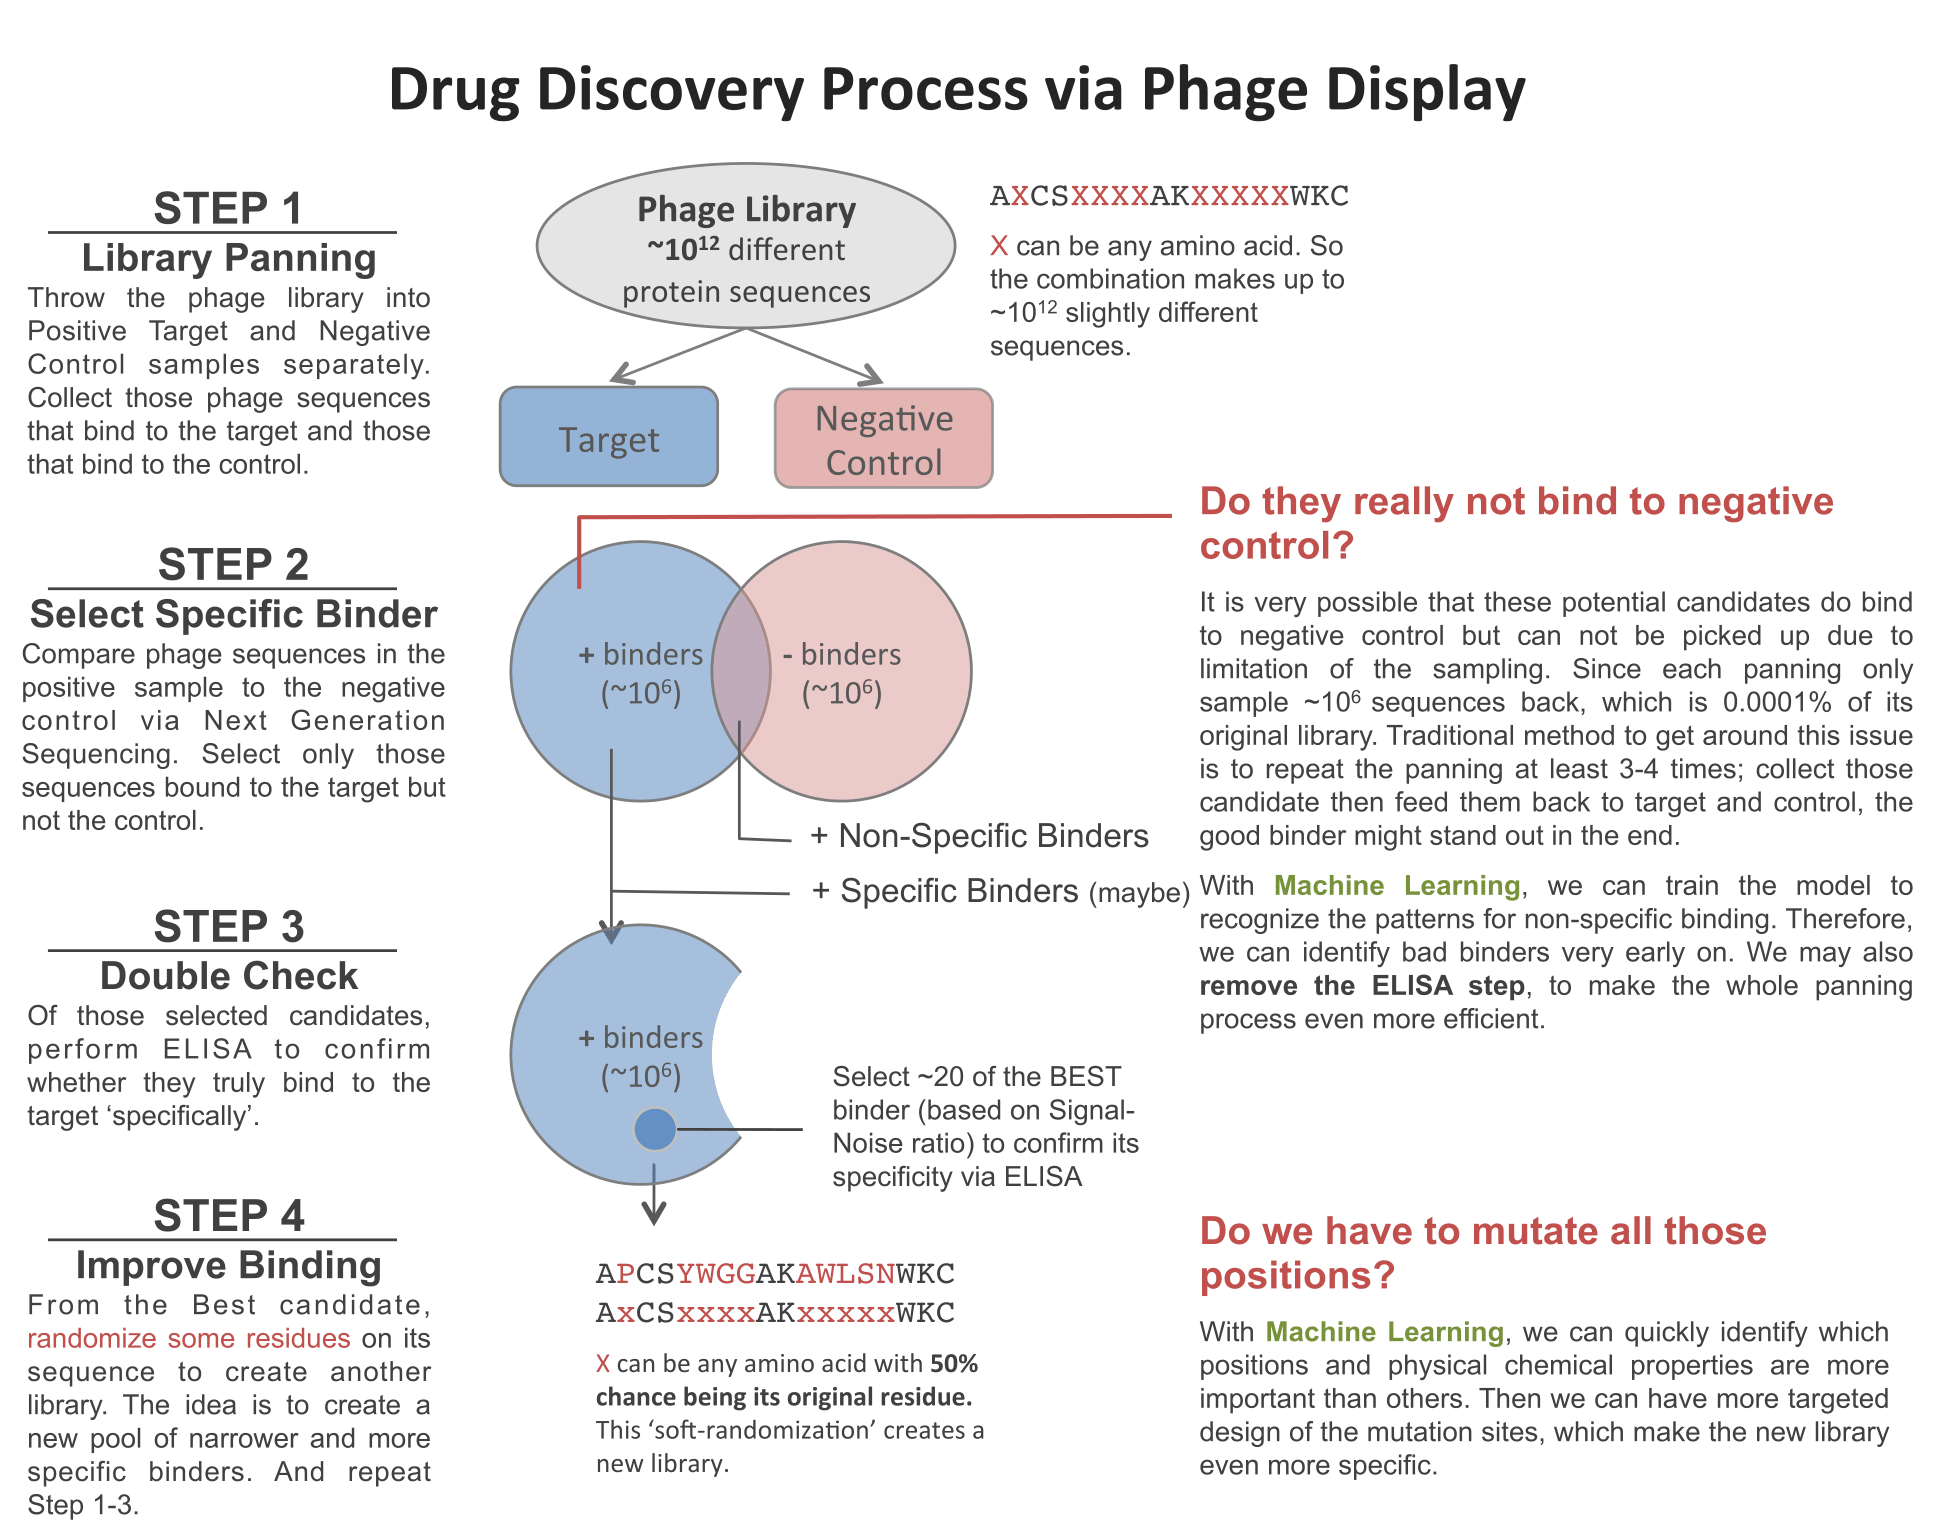

In [9]:
from IPython.display import Image
picpath1 = '~/Intro_1.png'
picpath2 = '~/Intro_2.png'
Image(picpath1)

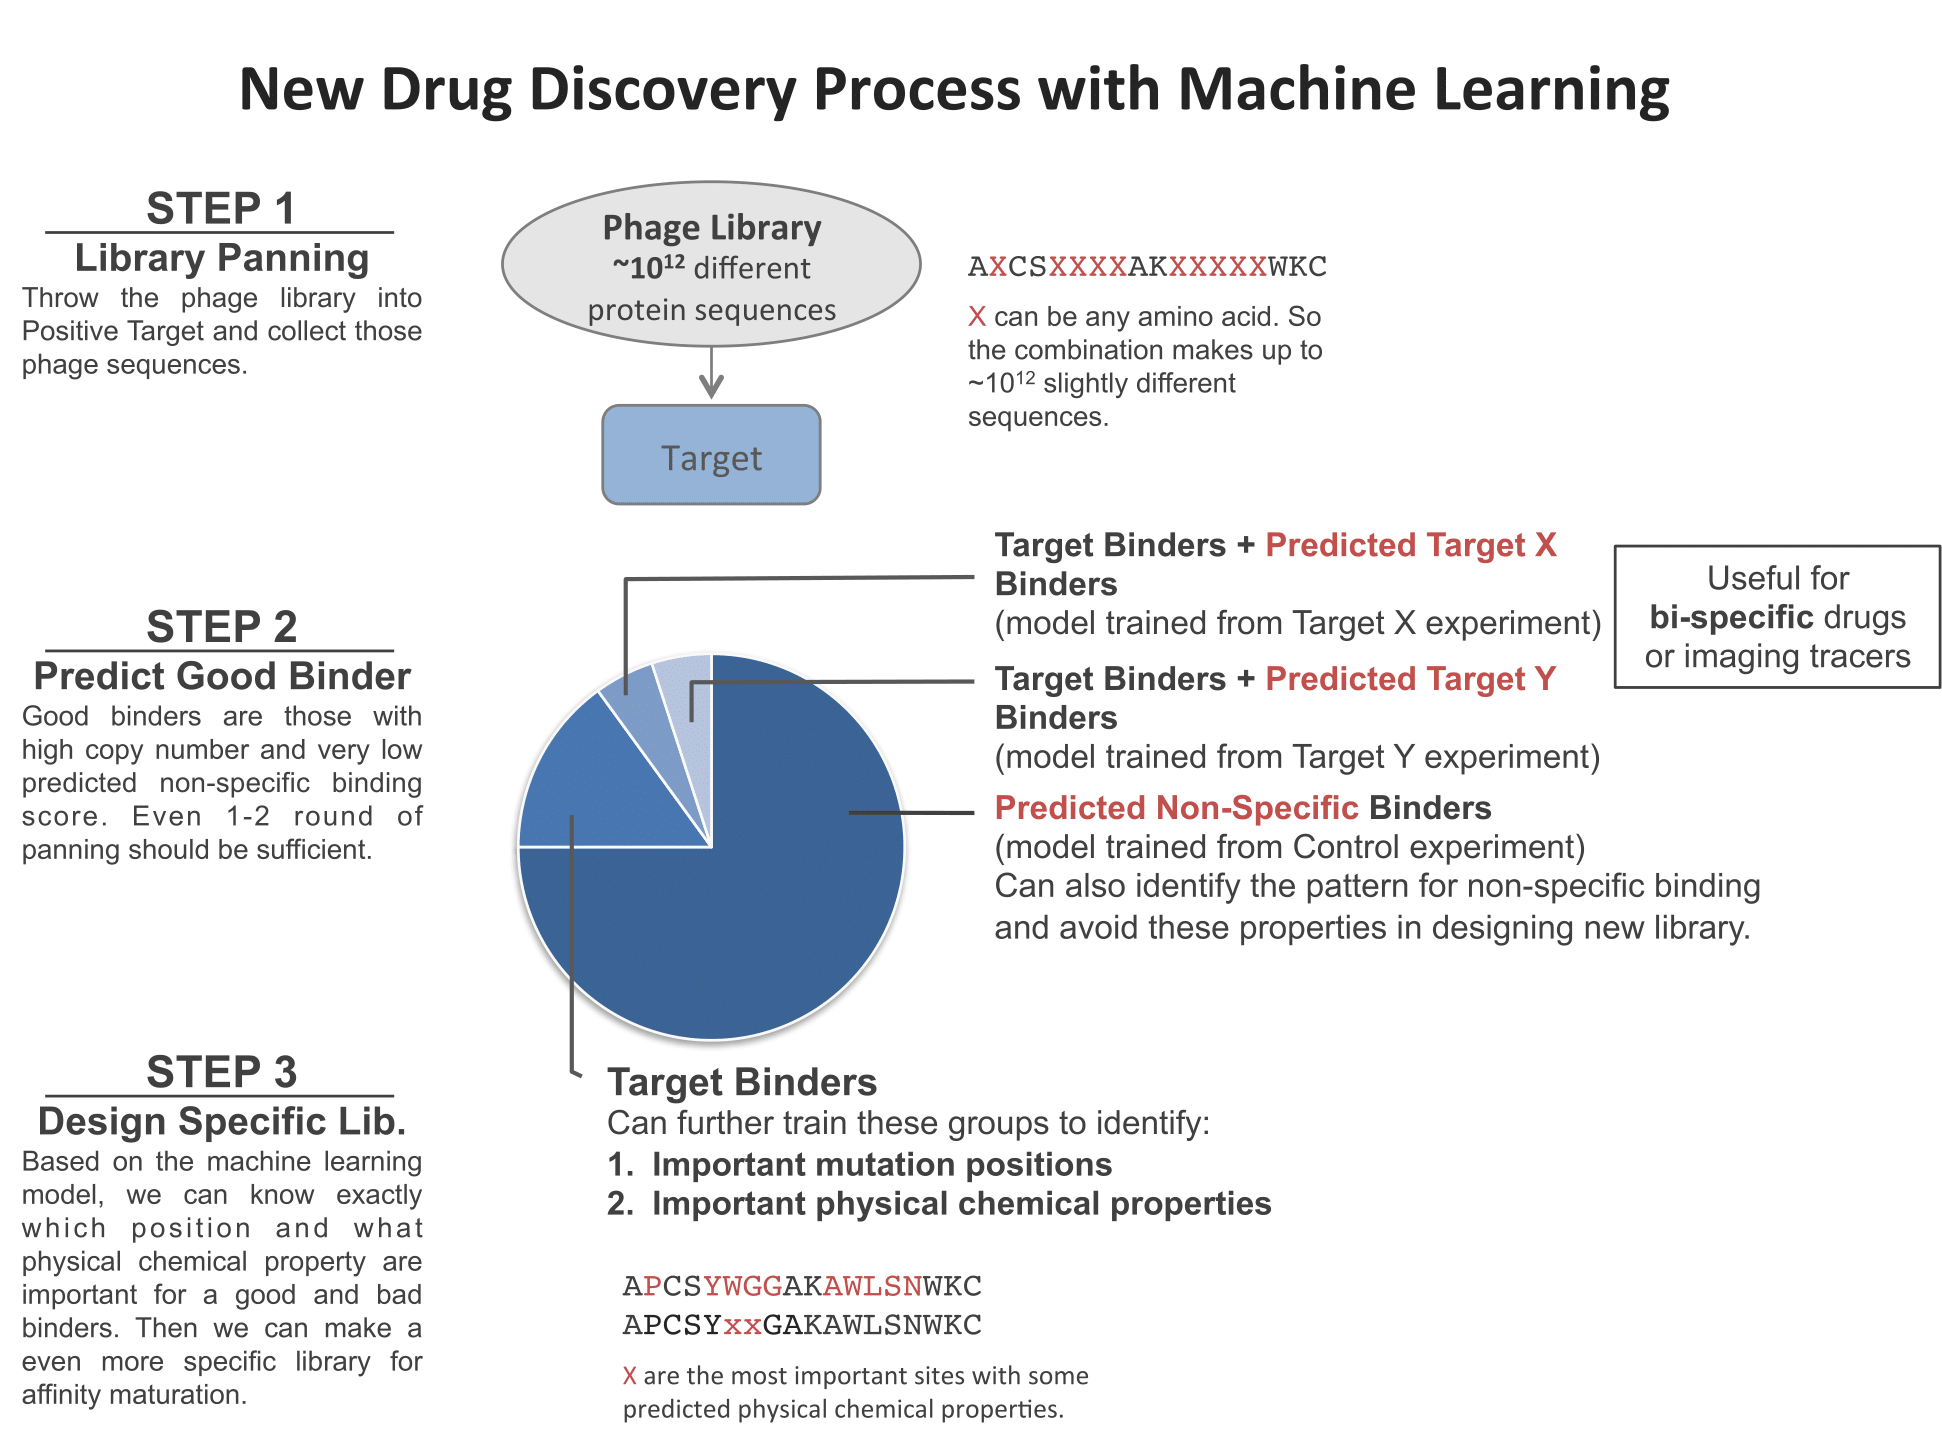

In [10]:
Image(picpath2)

## Data Source

The data testing here is only one round of panning data read by MiSeq. 

We can also include additional round and engineer some additional features to improve the predicting power. (This is my ongoing project)

### Data Loading and Cleaning 

In [12]:
import pandas as pd
import numpy as np
#import sys
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

/Users/changc25/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [13]:
filepath = 'xxx.xlsx'

flank_seq1 = 'xx'
flank_seq2 = 'xxxx'
flank_seq_len = 28

drop_fix_aa_loc = range(10,23) # non-mutated aa positions that need to be dropped
# above steps is to extract only those mutation positions

select_round1 = 'S/N_Percentage'

####################################
## extracting features and labels ##
####################################
data = pd.read_excel(filepath, header=0)
data['var_seq'] = data['Peptide'].str.extract(flank_seq1+'(.*)'+flank_seq2) # extracting just the mutation positions. Or '(.+?)'
# data['var_seq'] = data['Peptide'].str.extract(flank_seq1+'(.*)'+flank_seq2, expand=False) # for newer version
# select only the right seq length, this is important for generating fasta file
data = data.loc[data.var_seq.str.len() == flank_seq_len,]

s_data = data.loc[data[select_round1] >= 0, [select_round1, 'var_seq']] # select the data that contain S/N ratio

/Users/changc25/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


#### Take a look at the raw data (first 10 sequences):

In [1]:
# data.iloc[:10,[9,12,13,14]] # showing only important columns

#### Take a quick look at the S/N distribution before we subset them into different labels 
The **ultimate goal** is to predict **continuous** binding strength (S/N ratio) given some sequences. Here is the histogram of all sequences' S/N ratio in the data. 

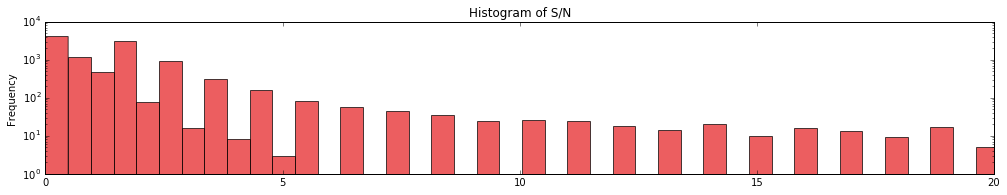

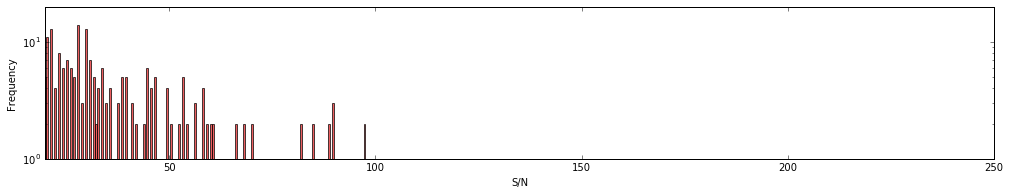

In [4]:
plt.rcParams['figure.figsize'] = (17.0, 6.0)
plt.figure(1)
plt.subplot(211)
s_data[select_round1].plot(colormap='Set1', kind='hist', alpha=0.7, bins=500, xlim=(0,20)) #ylim=(0,30)
plt.title('Histogram of S/N')
plt.yscale('log')
plt.figure(2)
plt.subplot(212)
s_data[select_round1].plot(colormap='Set1', kind='hist', alpha=0.7, bins=500,  xlim=(20,250), ylim=(1,20)) 
plt.xlabel('S/N')
plt.yscale('log')
plt.show()

To predict a continuos binding strength, it is better to have equally distributed S/N ratios across all range. However, the majority of current data has very low S/N. I am simply breaking them into 5 groups:

- (label: 4) Great: S/N > 10
- (label: 3) OK: 4 - 10
- (label: 2) Neutral: 1 - 4
- (label: 1) Bad: 0.1 - 1
- (label: 0) Very Bad: 0 - 0.1

Since there is no clear boundry from the histogram that allows us to seperate them, I am using my experience and intuition to set the range for each group.  We can tweak those ranges to get a better prediction. Or we can remove some groups to make a conservative but more accurate prediction (for instance, Good vs. Neutral vs. Bad). 

In [15]:
# (instead of directly using S/N ratio) make 5 'labels'
idx_Great = s_data[select_round1] > 10
idx_Good = (s_data[select_round1] <= 10) & (s_data[select_round1] > 4)
idx_Neutral = (s_data[select_round1] <= 4) & (s_data[select_round1] > 1)
idx_Bad = (s_data[select_round1] <= 1) & (s_data[select_round1] >0.1 )
idx_VBad = (s_data[select_round1] <= 0.1) & (s_data[select_round1] >=0.0 )

# create a new Label for above groups
s_data.loc[idx_Great, 'Label'] = int(4)
s_data.loc[idx_Good, 'Label'] = int(3)
s_data.loc[idx_Neutral, 'Label'] = int(2)
s_data.loc[idx_Bad, 'Label'] = int(1)
s_data.loc[idx_VBad, 'Label'] = int(0)

#### S/N distribution in each group

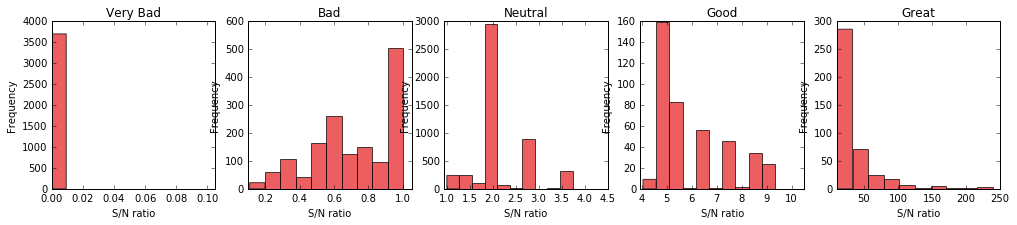

In [6]:
p_Great = s_data.loc[idx_Great, select_round1]
p_Good = s_data.loc[idx_Good, select_round1]
p_Neutral = s_data.loc[idx_Neutral, select_round1]
p_Bad = s_data.loc[idx_Bad, select_round1]
p_VBad = s_data.loc[idx_VBad, select_round1]

df = pd.concat([p_Great, p_Good, p_Neutral, p_Bad, p_VBad], axis=1)
df.columns = ['Great', 'Good', 'Neutral', 'Bad', 'VBad']

# Hist within each group
plt.rcParams['figure.figsize'] = (17.0, 3.0)
fig, axes = plt.subplots(nrows=1, ncols=5)
df.Great.plot(kind='hist', colormap='Set1', ax=axes[4], xlim=(10,250), alpha=0.7); axes[4].set_title('Great'); axes[4].set_xlabel("S/N ratio")
df.Good.plot(kind='hist', colormap='Set1', ax=axes[3], xlim=(3.95,10.5), alpha=0.7); axes[3].set_title('Good'); axes[3].set_xlabel("S/N ratio")
df.Neutral.plot(kind='hist', colormap='Set1', ax=axes[2], xlim=(0.95, 4.5), alpha=0.7); axes[2].set_title('Neutral'); axes[2].set_xlabel("S/N ratio")
df.Bad.plot(kind='hist', colormap='Set1', ax=axes[1], xlim=(0.1, 1.05), alpha=0.7); axes[1].set_title('Bad'); axes[1].set_xlabel("S/N ratio")
df.VBad.plot(kind='hist', colormap='Set1', ax=axes[0], xlim=(0, 0.105), alpha=0.7); axes[0].set_title('Very Bad'); axes[0].set_xlabel("S/N ratio")

Lots of sequences are in Neutral and Very Bad and then Bad groups. Relatively fewer sequences are in Good and Great. This imbalanced group might bias the machine learning model towrads predicting more Neutral then Great. To avoid this situation, I combine two methods and will describe them later:
1. Downsample the Neutral, Bad, and Very Bad groups to the size closer to Good and Great.
2. Introduce weights to each groups.
 
 (other methods like synthesising data of Good and Great may not be a good idea here, because protein sequences and their properties is very complex)

In [7]:
s_data.re_vg = s_data.loc[idx_Great]
s_data.re_g = s_data.loc[idx_Good]
s_data.re_n = s_data.loc[idx_Neutral]
s_data.re_b = s_data.loc[idx_Bad]
s_data.re_vb = s_data.loc[idx_VBad]
print 'The Sample Size in Great   : ', len(s_data.re_vg)
print 'The Sample Size in Good    : ', len(s_data.re_g)
print 'The Sample Size in Neutral : ', len(s_data.re_n)
print 'The Sample Size in Bad     : ', len(s_data.re_b)
print 'The Sample Size in Very Bad: ', len(s_data.re_vb)

The Sample Size in Great   :  418
The Sample Size in Good    :  415
The Sample Size in Neutral :  4848
The Sample Size in Bad     :  1538
The Sample Size in Very Bad:  3714


### Do these groups have distinct features in their amino acid positions?

/Users/changc25/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


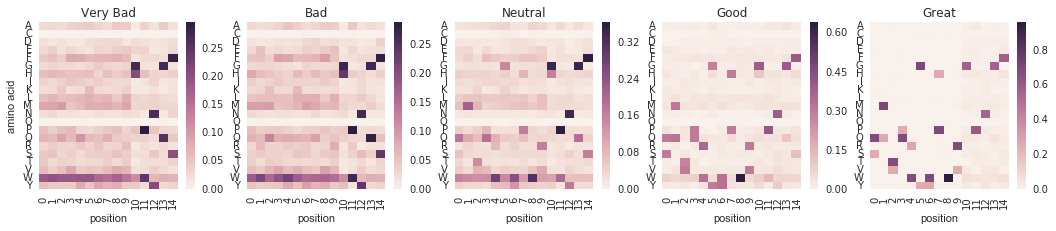

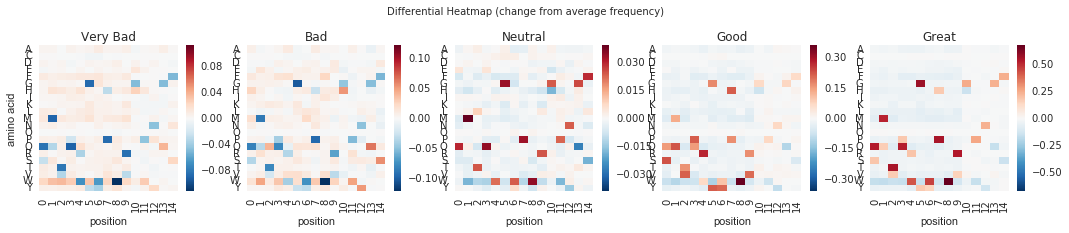

In [8]:
import sys
sys.path.append('~/NGS/Machine_Learning')
from phage_display_funcs import make_seq_heatmap_df
import seaborn as sns 
p5 = make_seq_heatmap_df(s_data.re_vg.var_seq, flank_seq_len, drop_fix_aa_loc)
p4 = make_seq_heatmap_df(s_data.re_g.var_seq, flank_seq_len, drop_fix_aa_loc)
p3 = make_seq_heatmap_df(s_data.re_n.var_seq, flank_seq_len, drop_fix_aa_loc)
p2 = make_seq_heatmap_df(s_data.re_b.var_seq, flank_seq_len, drop_fix_aa_loc)
p1 = make_seq_heatmap_df(s_data.re_vb.var_seq, flank_seq_len, drop_fix_aa_loc)

plt.rcParams['figure.figsize'] = (18, 3)
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1, ncols=5)
sns.heatmap(p5, ax=ax5); ax5.set_title('Great'); ax5.set_xlabel('position')
sns.heatmap(p4, ax=ax4); ax4.set_title('Good'); ax4.set_xlabel('position')
sns.heatmap(p3, ax=ax3); ax3.set_title('Neutral'); ax3.set_xlabel('position')
sns.heatmap(p2, ax=ax2); ax2.set_title('Bad'); ax2.set_xlabel('position')
sns.heatmap(p1, ax=ax1); ax1.set_title('Very Bad'); ax1.set_xlabel('position'); ax1.set_ylabel('amino acid')

p0 = (p5*len(s_data.re_vg)+p4*len(s_data.re_g)+p3*len(s_data.re_n)+p2*len(s_data.re_b)+p1*len(s_data.re_vb))/(len(s_data.re_vg)+len(s_data.re_g)+len(s_data.re_n)+len(s_data.re_b)+len(s_data.re_vb))

plt.rcParams['figure.figsize'] = (18, 3)
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1, ncols=5)
fig.subplots_adjust(top=0.8)
fig.suptitle('Differential Heatmap (change from average frequency)')
#sns.heatmap(p5-p0, ax=ax5, vmin=-0.3, vmax=0.3); ax5.set_title('Great'); ax5.set_xlabel('position')
sns.heatmap(p5-p0, ax=ax5); ax5.set_title('Great'); ax5.set_xlabel('position')
sns.heatmap(p4-p0, ax=ax4); ax4.set_title('Good'); ax4.set_xlabel('position')
sns.heatmap(p3-p0, ax=ax3); ax3.set_title('Neutral'); ax3.set_xlabel('position')
sns.heatmap(p2-p0, ax=ax2); ax2.set_title('Bad'); ax2.set_xlabel('position')
sns.heatmap(p1-p0, ax=ax1); ax1.set_title('Very Bad'); ax1.set_xlabel('position'); ax1.set_ylabel('amino acid')

Here we already can see distinct patterns among these groups, which means **Computer can do Better than Human Eys** if not worse. This heatmap representation is also similar to Logo plot. 

## Data Training and Prediction

### Generate Features and Labels

Since computer only takes numerical numbers as 'features' and 'labels', we have to transform our amino acid character into numbers. And we can further asign (encode) physical-chemical properties into each residues. There are several methods for this encoding, as reviewed here: [Benchmarking of protein descriptor sets in proteochemometric modeling (part 1): comparative study of 13 amino acid descriptor sets.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3848949/)

Most of the encoding methods came from Pricipal Component Analysis (PCA) of AA Index dataset. After the PCA, the encoding features lost their physiological meaning and may be hard to interpret the machine learning result. 

So here I am using simple encoding method that for each amino acid, we can describe its "Accessible surface area", "Free energy of solution in water", "Ploarity", "Isoelectric point", "Molecular Weight", and "Hydrophobicity". This is modified from [Quantitative prediction of mouse class I MHC peptide binding affinity using support vector machine regression (SVR) models.](http://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-182) We can always include more features to be more descriptive, but we might end up over-fitting. 

In [9]:
# Here are several encoding methods
aaindex_6 = pd.read_csv('~/NGS/Machine_Learning/AAIndex_6.csv', header=0, index_col=0)

display(aaindex_6.head())

,Average accessible surface area,Free energy of solution in water,Polarity,Isoelectric point,Molecular_Weight,Hydrophobicity
Amino Acid,,,,,,
A,0.141,0.262,0.000,0.404,0.436273,0.41
R,0.905,0.169,1.000,1.000,0.852960,-0.14
N,0.510,0.313,0.065,0.330,0.646918,-0.28
D,0.515,0.601,0.956,0.000,0.651765,-0.55
C,0.000,0.947,0.028,0.285,0.593253,0.49


#### How does the encoding work?

For example we want to encode this sequence: **QMQ**.  The first position Q will be [0.608, 0.416, 0.068, 0.360, 0.71, -0.1], where the first number is the surface area score, second number is the free energy score, third is polarity score and so on. And the second position M becomes [0.206, 0.405, 0.028, 0.372, 0.74, 0.4].  We do this for the rest of residues and then **concatenate** their list of numbers into a longer list, total of 20 numbers (3 residues * 6 features per residue): 

[0.608, 0.416, 0.068, 0.360, 0.71, -0.1, 0.206, 0.405, 0.028, 0.372, 0.74, 0.4, 0.608, 0.416, 0.068, 0.360, 0.71, -0.1]

Position 0-5 (using Python's indexing scheme) describes the first amino acid with properties of surface area, free energy, polarity, isoelectric point ... in order. Position 6-11 describe the second amino acid and so on.  

In our case, each sequence has 15 amino acids, so the number of feature per sequence is 15\*6 = **90 features/seq**. 

This may seem a lot. We can quickly check whether there is any significant correlation within this four physical-chemical proterties. If there is, we can remove one of the correlated feature to prevent overfitting. 

#### Correlation Matrix for those features (help remove redundent features)

can also perform PCA to de-compose them and find most important features (again, using PCA may loose meaningful feature information)

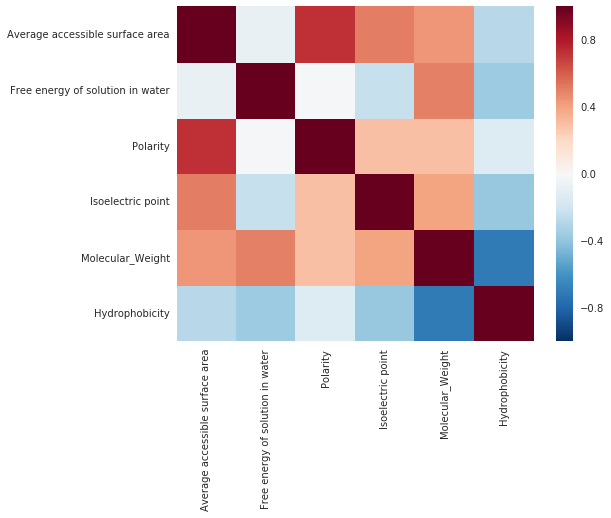

In [10]:
cor=aaindex_6.corr(method='pearson') # method : {‘pearson’, ‘kendall’, ‘spearman’}
plt.rcParams['figure.figsize'] = (8, 6)
sns.heatmap(cor)

These six physical-chemical properties are good encoding features to use since each of them is different from others. 

In [11]:
print "The Features of 'A':"
print VHSE.loc["A",:].tolist() 

The Features of 'A':
[0.14999999999999999, -1.1100000000000001, -1.3500000000000001, -0.92000000000000004, 0.02, -0.91000000000000003, 0.35999999999999999, -0.47999999999999998]


### Applying this encoding method to the whole data set

In [31]:
# append them together
s_data.re = s_data.re_vg.append([s_data.re_g, s_data.re_n, s_data.re_b, s_data.re_vb])
seqs = s_data.re.var_seq 

# converting aa seq into number as shown in aa_label
seq_feature = []
for seq in seqs:
    string = pd.Series(list(seq))
    string.drop(drop_fix_aa_loc, inplace=True) # remove concensus aa
    string.reset_index(drop=True, inplace=True) # reset the index for the next step
    for index, charc in enumerate(string):
        string[index] = aaindex_6.loc[charc,:].tolist()
    seq_feature.append(string)

seq_feature = np.array(seq_feature)
seq_label = s_data.re.Label.reset_index(drop=True)
seq_label = np.array(seq_label).astype(int)

num_total_sample = seq_feature.shape[0]
num_aa = seq_feature.shape[1]
num_chemprop = seq_feature.shape[2]

print '%d samples. Each sample has %d features, with %d values per feature.' %(num_total_sample, num_aa, num_chemprop)
print '%d labels.' %(seq_label.shape[0])

10933 samples. Each sample has 15 features, with 6 values per feature.
10933 labels.


'Label' defines the group where the particular sequence belongs to. 

## Feature Engineering (key to improve accuracy)

Istead of simply using amino acid positions with encoding, I added the 'cluster ID' as additional feature to each sequence. This additional feature improves the accuracy by 10%!

This **Cluster ID** is generated by performing **'sequence alignment'** on the entire sequence. This process is so called **unsupervised machine learning**, and it groups similar sequences into different clusters (with a Cluster ID). 

So during this entire machine learning process, the computer not only considers the sequences themselves, it also compares the similarity between other sequences.

In [ ]:
seq_feature_temp = seq_feature.tolist()
print "Shape before adding Cluster ID: ", np.shape(seq_feature_temp)

for i, sub_feat in enumerate(seq_feature_temp):
    sub_feat.append(seq_cID[i])

print "Shape after adding Cluster ID:", np.shape(seq_feature_temp)
seq_feature_wCID = np.array(seq_feature_temp)

print "the 1st seq_feature:\n", seq_feature_wCID[0]

### Split Training and Testing datasets

We will use 80% of the data for training and 20% for testing our prediction accuracy.

StratifiedShuffleSplit splits Train and Test (n sets of Train and Test) in a way that the ratio in each labels is preserved. 

In [16]:
from sklearn.model_selection import GridSearchCV, validation_curve, StratifiedShuffleSplit
from sklearn import metrics
from sklearn.metrics import classification_report

In [35]:
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42) # n_splits=1 is equivalent to regular splitter
sss.get_n_splits(seq_feature, seq_label)
for train_index, test_index in sss.split(seq_feature, seq_label):
    print("# TRAIN:", train_index.shape[0], "# TEST:", test_index.shape[0])
    features_train, features_test = seq_feature[train_index], seq_feature[test_index]
    features_wCID_train, features_wCID_test = seq_feature_wCID[train_index], seq_feature_wCID[test_index]
    labels_train, labels_test = seq_label[train_index], seq_label[test_index]    

('# TRAIN:', 8746, '# TEST:', 2187)
('# TRAIN:', 8746, '# TEST:', 2187)
('# TRAIN:', 8746, '# TEST:', 2187)


## Dealing with Imbalanced Data

Here I downsample the Very Bad, Bad, and Neutral groups by removing similar sequences. This is done by selecting only one sequence in each unique Cluster ID.

### Down-sampling based on Cluster ID

In [36]:
s_data.re.train=s_data.re.iloc[train_index,] # select 'trained' samples from the index generated by StratifiedShuffleSplit above.
temp = s_data.re.train.sort_values(select_round1, ascending=False) # sort the S/N values from Hight to Low, and select the first of each cluster

# choose which labels need to be down-sampled
label_nums = [0, 1, 2]

untouched_idx = np.array(labels_train == 4) | np.array(labels_train == 3) # label 3 and 4 are not down-sampled

# create new feature and label lists for down-sample
#features_train_ds = features_train[untouched_idx] # untouched labels
#labels_train_ds = labels_train[untouched_idx] # untouched labels

ds_idx = [] # down-sampled indices

for label_num in label_nums:
    clusters = temp.loc[temp.Label == label_num, 'Cluster'].unique() # unique clusters
    print 'Label = %d has %d unique seqs out of %d total trained seqs' %(label_num, len(clusters), sum(temp.Label == label_num))
    for cluster in clusters:
        # get the index of the first seq in the selected cluster as the 'representative seq' in the cluster
        a = temp[(temp.Label == label_num) & (temp.Cluster == cluster)].index[0] 
        bool_list = s_data.re.train.index == a
        # get the index of the 'representative seq' in 'features_train'
        b = [i-1 for i, elem in enumerate(bool_list, 1) if elem] # since 'enumerate' starts at 1 but index starts at 0
        ds_idx.append(b[0])
        
features_train_ds = np.concatenate((features_train[untouched_idx], features_train[ds_idx]))
features_wCID_train_ds = np.concatenate((features_wCID_train[untouched_idx], features_wCID_train[ds_idx]))
labels_train_ds = np.append(labels_train[untouched_idx], labels_train[ds_idx])

print ""

for label in [0,1,2,3,4]:
    print "Label %d is down-sample to %d seqs from total of %d seqs" %(label, sum(labels_train_ds == label), sum(labels_train == label))

Label = 0 has 2408 unique seqs out of 2971 total trained seqs
Label = 1 has 1050 unique seqs out of 1230 total trained seqs
Label = 2 has 2741 unique seqs out of 3878 total trained seqs

Label 0 is down-sample to 2408 seqs from total of 2971 seqs
Label 1 is down-sample to 1050 seqs from total of 1230 seqs
Label 2 is down-sample to 2741 seqs from total of 3878 seqs
Label 3 is down-sample to 332 seqs from total of 332 seqs
Label 4 is down-sample to 335 seqs from total of 335 seqs


### Calculate Sample Weights for Classification

In [37]:
sample_weight_list = len(labels_train_ds) / (5.0*np.bincount(labels_train_ds)) # 5.0 is the number of class in float
print "sample_weight for VBad, Bad, Neutral, Good, Great:\n", sample_weight_list

# for further weighting
#sample_weight_list[1] = sample_weight_list[1]*2
#sample_weight_list[3] = sample_weight_list[3]*4
#sample_weight_list[4] = sample_weight_list[4]*3
#print "adjusted sample_weight for VBad, Bad, Neutral, Good, Great:\n", sample_weight_list

sample_weight = []
sample_weight_ds = []
for label in labels_train_ds:
    sample_weight_ds.append(sample_weight_list[label])

for label in labels_train:
    sample_weight.append(sample_weight_list[label])
    
sample_weight = np.array(sample_weight)
sample_weight_ds = np.array(sample_weight_ds)

sample_weight for VBad, Bad, Neutral, Good, Great:
[ 0.57026578  1.30780952  0.50098504  4.13614458  4.09910448]


## Training and Prediction

For simplicity, I am only showing the result of XGBoost, since it has the best performance among SVM, Random Forest, and Ada Boost. 

In [20]:
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

>xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None)

The purpose of cross validation is to avoid overfitting. It randomly divides training set into N folds (cv_folds). Then it sets each fold aside for testing and trains on the remaining data. Thus it runs your parameters N times and then returns you mean performance on training and testing sets along with respective SDs. CV error needs to decrease at least every **early_stopping_rounds** round(s) to continue.



In [38]:
xgbc = XGBClassifier(
    max_depth=10, ## default = 6, range: [1,∞], higher is more likely to overfit
    learning_rate =0.01, # decrease this needs to increase the n_estimator
    n_estimators=3000, # higher value requires lower eta (n_estimators), = number of rounds of boosting (correcting error)
    silent = True,
    objective= 'multi:softmax', # binary:logistic, multi:softmax, multi:softprob
    nthread=-1,
    gamma=0.5,  ## [0,∞]. Larger, harder to split and control model complexity
    min_child_weight=6, ## [0,∞], default = 1, minimum sum of instance weight (hessian) needed in a child, the larger, the more conservative the algorithm will be.
    max_delta_step = 5, ## [0,∞], default = 0, Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update
    subsample=0.6, ##(defalut = 1), [0,1] lower this will prevent overfitting
    colsample_bytree=0.8, ## [0,1], subsample ratio of columns when constructing each tree; control overfitting
    colsample_bylevel=1, # [0,1], subsample ratio of columns for each split, in each level
    reg_alpha=0, # default = 0, L1 regularization term on weights, increase this value will make model more conservative
    reg_lambda=1, # default = 1, L2 regularization term on weights, increase this value will make model more conservative.
    scale_pos_weight=5, ## default = 1, Control the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sum(negative cases) / sum(positive cases)
    base_score=0.5, 
    seed=0,
    missing=None)

In [39]:
# put the feature and label and weight into xgb.DMatrix for xgb.cv
dtrain = xgb.DMatrix(features_train_ds, labels_train_ds, weight = sample_weight_ds)
dtest = xgb.DMatrix(features_test, labels_test)

# get the hyperparamters and add 'num_class' for xgb.cv
param = xgbc.get_params()
param['num_class'] = len(np.unique(labels_train))

do xgb.cv to see how many rounds (n_estimators) are needed.

In [40]:
num_round = 100
xgb.cv(param, dtrain, num_round, nfold=5, metrics={'mlogloss'}, seed = 0, 
       early_stopping_rounds=10, verbose_eval=True, as_pandas = True) 
      #callbacks=[xgb.callback.print_evaluation(show_stdv=False), xgb.callback.early_stop(3)])

[0]	train-mlogloss:1.60185+0.0001501	test-mlogloss:1.60467+0.000254294
[1]	train-mlogloss:1.59436+0.000183808	test-mlogloss:1.59988+0.000280135
[2]	train-mlogloss:1.58693+0.000334765	test-mlogloss:1.59524+0.000483785
[3]	train-mlogloss:1.57961+0.000404166	test-mlogloss:1.59069+0.00068806
[4]	train-mlogloss:1.57244+0.000413904	test-mlogloss:1.58623+0.000943237
[5]	train-mlogloss:1.56542+0.000276714	test-mlogloss:1.58192+0.00109735
[6]	train-mlogloss:1.55836+0.000292188	test-mlogloss:1.5775+0.00122259
[7]	train-mlogloss:1.55149+0.000334071	test-mlogloss:1.57331+0.00133272
[8]	train-mlogloss:1.54457+0.000556544	test-mlogloss:1.56912+0.00132625
[9]	train-mlogloss:1.53775+0.000650086	test-mlogloss:1.56498+0.00155747
[10]	train-mlogloss:1.53109+0.000775942	test-mlogloss:1.56083+0.00177706
[11]	train-mlogloss:1.52447+0.000878713	test-mlogloss:1.55678+0.00216578
[12]	train-mlogloss:1.51792+0.000831324	test-mlogloss:1.55282+0.0023529
[13]	train-mlogloss:1.51145+0.000851776	test-mlogloss:1.54889

,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
0,1.604668,0.000254,1.601852,0.000150
1,1.599878,0.000280,1.594364,0.000184
2,1.595240,0.000484,1.586932,0.000335
3,1.590693,0.000688,1.579610,0.000404
4,1.586233,0.000943,1.572444,0.000414
5,1.581920,0.001097,1.565424,0.000277
6,1.577505,0.001223,1.558359,0.000292
7,1.573305,0.001333,1.551490,0.000334
8,1.569123,0.001326,1.544565,0.000557
9,1.564982,0.001557,1.537754,0.000650


### Hyper-parameter Tuning:

1. n_estimator, learning_rate, (or combine 1 & 2 if you have strong computation power)
2. max_depth, min_child_weight
3. gamma, (scale_pos_weight)
4. reg_alpha
5. reduce learning_rate again

(6. subsample (range: (0,1]) and colsample_bytree (range: (0,1]))

In [41]:
# GridSearch for n_estimators and learning_rate first
cv_sets = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
parameters = {'n_estimators':[1000, 2000, 3000], 'learning_rate':[0.01, 0.05]}

grid = GridSearchCV(xgbc, parameters, cv=cv_sets, scoring = 'f1_weighted', n_jobs=3, fit_params={'sample_weight': sample_weight_ds})
grid.fit(features_wCID_train_ds, labels_train_ds)
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
print grid.best_estimator_

The best parameters are {'n_estimators': 1000, 'learning_rate': 0.01} with a score of 0.50
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.5, learning_rate=0.01, max_delta_step=5, max_depth=10,
       min_child_weight=6, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=5, seed=0, silent=True, subsample=0.6)


In [42]:
xgbc.set_params(**grid.best_params_) # kwargs: take the dict and pass it as function 'a': x => a=x

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.5, learning_rate=0.01, max_delta_step=5, max_depth=10,
       min_child_weight=6, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softmax', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=5, seed=0, silent=True, subsample=0.6)

In [43]:
#GridSearch for max_depth and min_child_weight 
parameters = {'max_depth':[10, 15, 20], 'min_child_weight':[2, 5, 8]}

grid = GridSearchCV(xgbc, parameters, cv=cv_sets, scoring = 'f1_weighted', n_jobs=3, fit_params={'sample_weight': sample_weight_ds})
grid.fit(features_wCID_train_ds, labels_train_ds)
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
print grid.best_estimator_

The best parameters are {'max_depth': 15, 'min_child_weight': 2} with a score of 0.50
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.5, learning_rate=0.01, max_delta_step=5, max_depth=15,
       min_child_weight=2, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=5, seed=0, silent=True, subsample=0.6)


In [44]:
xgbc.set_params(**grid.best_params_)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.5, learning_rate=0.01, max_delta_step=5, max_depth=15,
       min_child_weight=2, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softmax', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=5, seed=0, silent=True, subsample=0.6)

In [45]:
#GridSearch for gamma and scale_pos_weight
parameters = {'gamma':[0.1, 0.5, 1], 'scale_pos_weight':[1,5]}

grid = GridSearchCV(xgbc, parameters, cv=cv_sets, scoring = 'f1_weighted', n_jobs=3, fit_params={'sample_weight': sample_weight_ds})
grid.fit(features_wCID_train_ds, labels_train_ds)
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
print grid.best_estimator_

The best parameters are {'scale_pos_weight': 1, 'gamma': 0.5} with a score of 0.50
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.5, learning_rate=0.01, max_delta_step=5, max_depth=15,
       min_child_weight=2, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)


In [46]:
xgbc.set_params(**grid.best_params_)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.5, learning_rate=0.01, max_delta_step=5, max_depth=15,
       min_child_weight=2, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softmax', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

In [47]:
#GridSearch for reg_alpha
parameters = {'reg_alpha':[0, 0.5, 1, 5]}

grid = GridSearchCV(xgbc, parameters, cv=cv_sets, scoring = 'f1_weighted', n_jobs=3, fit_params={'sample_weight': sample_weight_ds})
grid.fit(features_wCID_train_ds, labels_train_ds)
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
print grid.best_estimator_

The best parameters are {'reg_alpha': 0} with a score of 0.50
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.5, learning_rate=0.01, max_delta_step=5, max_depth=15,
       min_child_weight=2, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)


In [48]:
xgbc.set_params(**grid.best_params_)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.5, learning_rate=0.01, max_delta_step=5, max_depth=15,
       min_child_weight=2, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softmax', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

In [49]:
#GridSearch for learning_rate again
parameters = {'learning_rate':[0.005, 0.007, 0.01]}

grid = GridSearchCV(xgbc, parameters, cv=cv_sets, scoring = 'f1_weighted', n_jobs=3, fit_params={'sample_weight': sample_weight_ds})
grid.fit(features_wCID_train_ds, labels_train_ds)
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
print grid.best_estimator_

The best parameters are {'learning_rate': 0.01} with a score of 0.50
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.5, learning_rate=0.01, max_delta_step=5, max_depth=15,
       min_child_weight=2, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)


In [50]:
xgbc.set_params(**grid.best_params_)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.5, learning_rate=0.01, max_delta_step=5, max_depth=15,
       min_child_weight=2, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softmax', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6)

In [51]:
# down-sample with weight
t0 = time() 
#xgbc = grid.best_estimator_
#xgbc.set_params(max_delta_step=10) # try adjusting some hyperparamters

xgbc.fit(features_wCID_train_ds, labels_train_ds, sample_weight=sample_weight_ds, 
         eval_set = [(features_wCID_test, labels_test)], eval_metric = 'mlogloss', 
         early_stopping_rounds=50) #eval_set = watchlist, early_stopping_rounds=10

print "training time:", round(time()-t0, 3), "s" # time the training process
score = xgbc.score(features_wCID_test, labels_test)
print "accuracy: ", round(score, 2) # print out the scores
    
print classification_report(labels_test, xgbc.predict(features_wCID_test))

print "important features are: \n", xgbc.feature_importances_[:-1].reshape([num_aa, num_chemprop])
print "\nCluster ID importance:", xgbc.feature_importances_[-1]

[0]	validation_0-mlogloss:1.60577
Will train until validation_0-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.60099
[2]	validation_0-mlogloss:1.5968
[3]	validation_0-mlogloss:1.5927
[4]	validation_0-mlogloss:1.58812
[5]	validation_0-mlogloss:1.58433
[6]	validation_0-mlogloss:1.58008
[7]	validation_0-mlogloss:1.57663
[8]	validation_0-mlogloss:1.57245
[9]	validation_0-mlogloss:1.56811
[10]	validation_0-mlogloss:1.56405
[11]	validation_0-mlogloss:1.56015
[12]	validation_0-mlogloss:1.55612
[13]	validation_0-mlogloss:1.55237
[14]	validation_0-mlogloss:1.54883
[15]	validation_0-mlogloss:1.54485
[16]	validation_0-mlogloss:1.54125
[17]	validation_0-mlogloss:1.53723
[18]	validation_0-mlogloss:1.53366
[19]	validation_0-mlogloss:1.53001
[20]	validation_0-mlogloss:1.52671
[21]	validation_0-mlogloss:1.52367
[22]	validation_0-mlogloss:1.52107
[23]	validation_0-mlogloss:1.51794
[24]	validation_0-mlogloss:1.51431
[25]	validation_0-mlogloss:1.51099
[26]	validation_0-mlogloss:1.5078

In [ ]:
# save the trained model 
from sklearn.externals import joblib
filepath = '~/trained_model/'
filename = 'AAIndex6_wCID_20160107.pkl'
joblib.dump(xgbc, filepath+filename)

# xgbc_load = joblib.load('filename.pkl')

### Visualize the Important Features

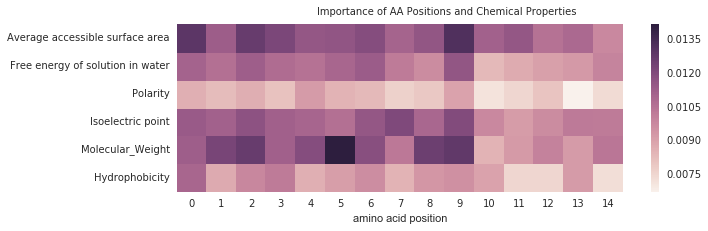

In [53]:
imp_features = xgbc.feature_importances_[:-1].reshape([num_aa, num_chemprop])
imp_features = pd.DataFrame(imp_features).T
imp_features.index = aaindex_6.columns.tolist()

plt.rcParams['figure.figsize'] = (10, 3)
fig, ax1 = plt.subplots(nrows=1, ncols=1)
fig.suptitle('Importance of AA Positions and Chemical Properties')
sns.heatmap(imp_features); ax1.set_xlabel('amino acid position')

**Cluster ID** highly improves the prediction accuracy. Its importance is also the highest among all other features.

Overall positions 0-9 are more important than 10-14 in terms of classifying sequence into correct binding strength, just like the Logo plot suggested. However, Logo plot might not easily spot the molecular weight at location 5 is very important. 

In addition, machine learning can provide further insight that we should put more consideration on **average accessible surface area** and **molecular weight** for having good binding to this particular target. And **polarity** and **hydrophobicity** (except position 0) might be less important. 

## The Predictions

The regular weight + down-sample + Cluster ID (increase the weight for Good and Great did not help):

>XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.5, learning_rate=0.01, max_delta_step=5, max_depth=20,
       min_child_weight=5, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softmax', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=5, seed=0, silent=True, subsample=0.6)

training time: 210.2 s

             precision    recall  f1-score   support

          0       0.61      0.61      0.61       743
          1       0.22      0.18      0.20       308
          2       0.56      0.49      0.52       970
          3       0.16      0.23      0.19        83
          4       0.32      0.81      0.46        83

      avg / total 0.50      0.49      0.49      2187

- precision: The precision is intuitively the ability of the classifier not to label as positive a sample that is negative
- recall: The recall is intuitively the ability of the classifier to find all the positive samples.
- f1-score: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

In [54]:
# labels_test = np.array(labels_test)
idx_test_vg = labels_test == 4
print "True Label - Great :", labels_test[idx_test_vg][:20]
print "The prediction says:", xgbc.predict(features_wCID_test)[idx_test_vg][:20]
print ""
idx_test_g = labels_test == 3
print "True Label - Good  :", labels_test[idx_test_g][:20]
print "The prediction says:", xgbc.predict(features_wCID_test)[idx_test_g][:20]
print ""
idx_test_n = labels_test == 2
print "True Label -Neutral:", labels_test[idx_test_n][:20]
print "The prediction says:", xgbc.predict(features_wCID_test)[idx_test_n][:20]
print ""
idx_test_b = labels_test == 1
print "True Label - Bad   :", labels_test[idx_test_b][:20]
print "The prediction says:", xgbc.predict(features_wCID_test)[idx_test_b][:20]
print""
idx_test_vb = labels_test == 0
print "True Label - V Bad :", labels_test[idx_test_vb][:20]
print "The prediction says:", xgbc.predict(features_wCID_test)[idx_test_vb][:20]

True Label - Great : [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
The prediction says: [4 4 0 4 4 4 4 4 4 4 3 4 3 4 4 4 2 4 4 4]

True Label - Good  : [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
The prediction says: [4 0 3 3 4 4 2 2 3 4 3 2 4 2 2 0 2 4 0 3]

True Label -Neutral: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
The prediction says: [0 2 1 2 1 2 2 2 0 0 2 0 1 1 1 3 2 1 0 3]

True Label - Bad   : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
The prediction says: [2 1 2 0 1 2 2 1 3 2 2 0 2 2 2 0 1 2 2 0]

True Label - V Bad : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
The prediction says: [2 1 0 1 1 0 0 0 0 1 0 0 2 0 0 0 2 0 1 0]


In [55]:
label_test_pred = xgbc.predict(features_wCID_test)

print "Great - accuracy: %0.2f" %(sum((labels_test[idx_test_vg] - label_test_pred[idx_test_vg]) == 0)/float(len(labels_test[idx_test_vg])))
print "Great - adjusted accuracy: %0.2f" %((sum(abs((labels_test[idx_test_vg] - label_test_pred[idx_test_vg])) == 1)+
                          sum((labels_test[idx_test_vg] - label_test_pred[idx_test_vg]) == 0) )/float(len(labels_test[idx_test_vg])))
print ""
print "Good - accuracy: %0.2f" %(sum((labels_test[idx_test_g] - label_test_pred[idx_test_g]) == 0)/float(len(labels_test[idx_test_g])))
print "Good - adjusted accuracy: %0.2f" %((sum(abs((labels_test[idx_test_g] - label_test_pred[idx_test_g])) == 1)+
                          sum((labels_test[idx_test_g] - label_test_pred[idx_test_g]) == 0) )/float(len(labels_test[idx_test_g])))
print ""
print "Neutral - accuracy: %0.2f" %(sum((labels_test[idx_test_n] - label_test_pred[idx_test_n]) == 0)/float(len(labels_test[idx_test_n])))
print "Neutral - adjusted accuracy: %0.2f" %((sum(abs((labels_test[idx_test_n] - label_test_pred[idx_test_n])) == 1)+
                          sum((labels_test[idx_test_n] - label_test_pred[idx_test_n]) == 0) )/float(len(labels_test[idx_test_n])))
print ""
print "Bad - accuracy: %0.2f" %(sum((labels_test[idx_test_b] - label_test_pred[idx_test_b]) == 0)/float(len(labels_test[idx_test_b])))
print "Bad - adjusted accuracy: %0.2f" %((sum(abs((labels_test[idx_test_b] - label_test_pred[idx_test_b])) == 1)+
                          sum((labels_test[idx_test_b] - label_test_pred[idx_test_b]) == 0) )/float(len(labels_test[idx_test_b])))
print ""
print "VBad - accuracy: %0.2f" %(sum((labels_test[idx_test_vb] - label_test_pred[idx_test_vb]) == 0)/float(len(labels_test[idx_test_vb])))
print "VBad - adjusted accuracy: %0.2f" %((sum(abs((labels_test[idx_test_vb] - label_test_pred[idx_test_vb])) == 1)+
                          sum((labels_test[idx_test_vb] - label_test_pred[idx_test_vb]) == 0) )/float(len(labels_test[idx_test_vb])))

Great - accuracy: 0.76
Great - adjusted accuracy: 0.94

Good - accuracy: 0.25
Good - adjusted accuracy: 0.88

Neutral - accuracy: 0.49
Neutral - adjusted accuracy: 0.68

Bad - accuracy: 0.17
Bad - adjusted accuracy: 0.97

VBad - accuracy: 0.61
VBad - adjusted accuracy: 0.74


The exact accuracy for Good, Neutral, and Bad groups is very low. However, this may be due to the definition of "Good", "Neutral", and "Bad" is already ambiguous. 

If we look at the actual predicting values, the prediction is still very close to the actual label. Therefore I calculate **Adjusted Accuracy**, which means the prediction is considered accurate if predicted label is within ± 1 of the actual label.

## Conculstion

Machine Learning can help us **quantitatively** and **quickly** decipher hidden information in the NGS phage display data. This is significantly useful in improving the efficiency of drug discovery process.


## Future Plans

**- Try TensorFlow (Google's neural network algorithm)**

**- Predict actual S/N ration by collecting more data and using Regression**